# Прогнозирование оттока
Мы сотрудники компании, которая предлагает услуги телефонной связи и Интернета, и у нас есть проблема: наблюдается отток некоторых из наших клиентов. Они перестают пользоваться нашими услугами и переходят у конкурентам. Мы хотели бы пресечь это явление, поэтому разрабатывает систему для выявления таких клиентов, чтобы предложить им какой-либо стимул, который позволит им остаться. Мы хотим нацелить на них свои рекламные сообщения и предоставить скидку. Мы также хотели бы понять, почему именно модель считает, что наши клиенты вот-вот уйдут.

Мы собрали набор данных, в который внесли определенную информацию о наших клиентах: какими услугами они пользовались, сколько платили и как долго оставались с нами. Мы таже знаем, кто расторг контракты и перестал пользоваться нашими услугами (в результате оттока). Будем использовать эту информацию в качестве целевой переменной в модели машинного обучения и прогнозировать, используя всю остальную доступную информацию.

План проект представлен ниже.
1. Сначала мы загрузим набор данных и выполнил некую первоначальную подготовку: переименуем столбцы и изменим значения внутри столбцов, чтобы они были согласованы по всему набору данных
2. Затем мы разделим данные на обучающие, проверочные тестовые, чтобы иметь возможность проверять наши модели.
3. В рамках первоначального анализа данных рассмотрим важность признаков, чтобы определить, какие из них важны в наших данных
4. Преобразуем категориальные переменные в числовые и, таким образом, сможем использовать их в модели.
5. Наконец, обучим модель логистической регрессии.

## Первичный осмотр данных

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
%matplotlib inline

In [3]:
# Теперь мы можем прочитать набор данных
df = pd.read_csv('data.csv')

In [4]:
# Увидим, сколько строк содержит датасет
len(df)

7043

В наборе данных содержится 7043 строки. Набор данных невелик, но его должно быть достаточно для обучения годной модели.

Далее взглянем на первые пару строк с помощью `head()`

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


В датафрейме довольно много столбцов, они все не помещаются на экране. Вместо этого транспонируем датафрейм

In [6]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


Мы видим, что набор данных состоит из нескольких столбцов.
- `CustomerID` — идентификатор клиента;
- `Gender` — мужчина/женщина;
- `SeniorCitizen` — является ли клиент пожилым (0/1);
- `Partner` — проживает ли он с партнером (да/нет);
- `Dependents` — имеются ли у него иждивенцы (да/нет);
- `Tenure` — количество месяцев с момента начала действия контракта;
- `PhoneService` — есть ли у него телефонная служба (да/нет);
- `MultipleLines` — имеется ли у него несколько телефонных линий (да/нет/нет телефонной связи);
- `InternetService` — тип интернет-сервиса (нет/кабель/оптоволокно);
- `OnlineSecurity` — подключена ли онлайн-безопасность (да/нет/нет Интернета);
- `OnlineBackup` — подключен ли онлайн-сервис резервного копирования (да/нет/нет Интернета);
- `DeviceProtection` — подключен ли сервис защиты устройств (да/нет/нет Интернета);
- `TechSupport` — есть ли у клиента техническая поддержка (да/нет/нет Интернета);
- `StreamingTV` — подключен ли сервис потоковой передачи ТВ (да/нет/нет Интернета);
- `StreamingMovies` — подключен ли сервис потоковой передачи фильмов (да/нет/нет Интернета);
- `Contract` — тип контракта (ежемесячный/годовой/двухлетний);
- `PaperlessBilling` — подключено ли электронное выставление счетов (да/нет);
- `PaymentMethod` — способ оплаты (электронный чек, чек по почте, банковский перевод, кредитная карта);
- `MonthlyCharges` — сумма, взимаемая ежемесячно (число);
- `TotalCharges` — общая сумма начислений (число);
- `Churn` — расторг ли клиент контракт (да/нет).

Самый интересный для нас пункт - это `Churn`. В качесте целевой переменной для нашей модели мы хотим научиться прогнозировать именно его.

## Предобработка данных

Сперва взглянем на типы данных

In [7]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

В целом, все в порядке. Однако есть два момента. Во-первых, SeniorCitizen определяется как integer, а не object. Во-вторых, TotalCharges неправильно идентифицирован как object, тогда как он должен быть float. Преобразуем его в числовой тип.

In [8]:
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')

Убедимся в том, что данные действительно содержат нечисловые символы.

In [9]:
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


Мы видим, что в столбце TotalCharges действительно встречаются пробелы. Заменим их на нули.

In [10]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

Также мы можем увидеть, что имена столбцов заданы в разных стилях. Приведем их к единообразию, в том числе и сами данные

In [11]:
# приводим названия столбцов к нижнему регистру
# меням пробелы на знак "_"
df.columns = df.columns.str.lower().str.replace(' ', '_')

# занесем столбцы со строковыми значениями в отдельный список
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

# проходим циклом по каждому столбцу с необходимыми заменами
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

Посмотрим, что у нас вышло

In [12]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,no
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,yes


Далее обратимся к нашей целевой переменной churn. Она принимает значения "yes" и "no". Преобразуем их в числа 1 и 0.

In [13]:
df.churn = (df.churn == 'yes').astype(int)

Теперь разобьем датасет на обучающую и тестовую выборку

In [14]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

Разделим датафрейм `df_train_full` еще раз, теперь уже на обучающий и проверочный наборы

In [15]:
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

# сохраним столбец churn за пределами датафрейма
y_train = df_train.churn.values
y_val = df_val.churn.values

# удалим churn из обоих датафреймов, чтобы они точно не попали
# в обучающий набор
del df_train['churn']
del df_val['churn']

Проверим даные на наличие отсутствующих значений

In [16]:
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

Нам не нужно обрабатывать отсутствующие знаения в наборе данных: все значения во всех столбцах присутствуют.

## Исследовательский анализ данных

Мы должны проверить распределение значений в целевой переменной. Используем для этого `value_counts()`

In [17]:
df_train_full.churn.value_counts()

0    4113
1    1521
Name: churn, dtype: int64

Как мы видим большинство клиентов не расторгали контракт. Проверим долю ушедших пользователей среди всех клиентов.

In [18]:
global_mean = df_train_full.churn.mean()
round(global_mean, 3)

0.27

Услугами перестали пользоваться примерно 27% клиентов.

Теперь создадим два списка. В первом будут категориальные переменные, во втором - числовые.

In [19]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
              'onlinesecurity', 'onlinebackup', 'deviceprotection',
              'techsupport', 'streamingtv', 'streamingmovies',
              'contract', 'paperlessbilling', 'paymentmethod']

numerical = ['tenure', 'monthlycharges', 'totalcharges']

Узнаем, сколько уникальных значений содержит каждая переменная

In [20]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

Мы видим, что большинство столбцов имеют два или три значения, а один (paymentmethod) - четыре.

### Важность признака

Знание влияния других переменных на целевую - ключ к пониманию данных и построению хорошей модели. 

Начнем с рассмотрения категориальных переменных. Посмотри, как проявляется коэффициент оттока в зависимости от пола клиента.

In [21]:
female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
print('gender == female', round(female_mean, 3))
male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print('gender == male', round(male_mean, 3))

gender == female 0.277
gender == male 0.263


Уровень оттока клиентов женщин составляет 27,7%, а клиентов-мужчин - 26,6%, в то время как глобальный уровень оттока составляет 27%. Разница между долей оттока среди женщин и оттоком среди мужчин довольно мала. Это указывает на то, что значение пола не поможет определить, расторгнет ли клиент договор.

Теперь взглянем на переменную partner

In [22]:
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
print('parner == yes', round(partner_yes, 3))
partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()
print('partner == no', round(partner_no, 3))

parner == yes 0.205
partner == no 0.33


Коэффициенты сильно отличаются. Это означает, что клиенты, у которых нет партнера, имеют больше шансов расторгнуть договор, чем те, у кого он есть.

Высчитаем коэффициент риска (отношение оттока группы к глобальному оттоку) для каждого пола. Для этого сгруппируем датасет.

In [23]:
df_group = df_train_full.groupby(by='gender').churn.agg(['mean'])

# Вычислим разницу между коэффициентом оттока группы и 
# глобальным коэффициентом
df_group['diff'] = df_group['mean'] - global_mean

# Вычислим риск оттока
df_group['risk'] = df_group['mean'] / global_mean

df_group

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


Мы видим, что для обоих значений разница между коэффициентом группового оттока и глобальным коэффициентом оттока не слишком велика. Проделаем это для всех категориальных переменных.

In [24]:
for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['rate'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,rate
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,rate
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


,mean,diff,rate
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,rate
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,rate
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,rate
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,rate
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,rate
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,rate
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,rate
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,rate
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,rate
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,rate
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,rate
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,rate
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,rate
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


Из результатов мы узнаем следующую информацию:
- Что касается пола, то между женщинами и мужчинами нет большой разницы. Оба средних примерно одинаковы, и для обеих групп риски близки к 1.
- Пожилые люди склонны к оттоку больше, чем те, кто не является пенсионером: риск оттока составляет 1,53 для пожилых людей и 0,89 для остальных.
- У людей, имеющих парнера, отток меньше, чем у людей без партнера. Риски составляют 0,75 и 1,22 соответственно.
- Люди, пользующиеся телефонной связью, не подвержены риску оттока: риск близок к 1, и почти нет разницы в сравнении с общим уровнем оттока. Люди, которые не пользуются телефонной связью, еще менее склонны к оттоку: риск ниже 1, а разница с общим показателем отрицательна

Некоторые переменные показывают довольно существенные различия:
- Клиенты, не имеющие технической поддержки, как правило, уходят чаще, чем те, у кого она есть
- Люди, с которыми заключен ежемесячный контракт, расторгают его намного чаще, чем остальные, а люди с двухлетними контрактами уходят очень редко.

### Взаимная информация

Мы можем измерить степень зависимости между категориальной и целевой переменной. Для этого есть функция `mutual_info_score`

In [25]:
# Создадим автономную функцию для вычисления взаимной информации
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

# Применим функцию "calculate_mi" к каждому категориальному столбцу
df_mi = df_train_full[categorical].apply(calculate_mi)

# Сортируем значения результата
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


Как мы видим, contract, onlinesecurity и techsupport относятся к числу наиболее важных признаков. Действительно, мы уже отмечали, что contract и techsupport довольно информативны. Неудивительно и то, что gender является одним из наименее важных признаков, поэтому не стоит ожидать, что он окажется полезным для модели.

### Коэффициент корреляции

Когда один из признаков числовой, оценка степени зависимости не сработает. Для этого существует коэффициент корреляции. Рассчитать его в Pandas очень легко.

In [26]:
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

Переменная tenure имеет высокую отрицательную корреляцию: по мере роста срока контракта уровень 
оттока снижается. monthlycharges имеет положительную корреляцию: чем больше клиенты платят, тем выше вероятность их оттока

## Конструирование признаков

Для конструирования признаков воспользуемся DictVectorizer. 

Как следует из названия, DictVectorizer, берет словарь и векторизирует его, то есть создает из него вектор. Затем векторы складываются в виде строк одной матрицы. Эти матрицы и используются в качестве входных данных для алгоритма машинного обучения. 

Чтобы использовать этот метод, нам потребуется преобразовать датафрейм в список словарей, для чего можно использовать `to_dict` c параметром `orient='records'`

In [27]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# Создаем экзмепляр DictVectorizer
# Параметр sparse=False означает, что созданная матрица не будет разреженной
dv = DictVectorizer(sparse=False)

# Обучим его методом fit
dv.fit(train_dict)

DictVectorizer(sparse=False)

Теперь мы может преобразовать словари в матрицу с помощью метода `transform`

In [28]:
# Эта операция создает матрицу с 45 столбцами
X_train = dv.transform(train_dict)

# Взгленем на первую строку, которая соответствует первому клиенту
X_train[0]

array([0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 8.6100e+01, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 7.1000e+01, 6.0459e+03])

In [29]:
# Мы можем узать имена всех этих столбцов методом get_feature_name
dv.get_feature_names()

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male',
 'internetservice=dsl',
 'internetservice=fiber_optic',
 'internetservice=no',
 'monthlycharges',
 'multiplelines=no',
 'multiplelines=no_phone_service',
 'multiplelines=yes',
 'onlinebackup=no',
 'onlinebackup=no_internet_service',
 'onlinebackup=yes',
 'onlinesecurity=no',
 'onlinesecurity=no_internet_service',
 'onlinesecurity=yes',
 'paperlessbilling=no',
 'paperlessbilling=yes',
 'partner=no',
 'partner=yes',
 'paymentmethod=bank_transfer_(automatic)',
 'paymentmethod=credit_card_(automatic)',
 'paymentmethod=electronic_check',
 'paymentmethod=mailed_check',
 'phoneservice=no',
 'phoneservice=yes',
 'seniorcitizen',
 'streamingmovies=no',
 'streamingmovies=no_internet_service',
 'streamingmovies=yes',
 'streamingtv=no',
 'streamingtv=no_internet_servic

Теперь наши функции закодированы в виде матрицы, поэтому мы может перейти к следующему шагу: использованию модели для прогнозирования оттока.

## Машинное обучение для классификации

### Логистическая регрессия

In [30]:
# Обучим логистическую регрессию
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

Модель обучена. Теперь посмотрим, насколько хорошо она работает. Применим ее к нашим проверочным данным.

In [31]:
# Мы выполняем прямое кодирование точно также, как и во время обучения
val_dict = df_val[categorical + numerical].to_dict(orient='records')

# Используем преобразование, которое подгоняли ранее
X_val = dv.transform(val_dict)

В результате мы получаем X_val матрицу с признаками из проверочного набора данных. Теперь мы готовы применить ее к модели. Чтобы получить вероятности, мы используем метод модели `predict_proba`

In [32]:
y_pred = model.predict_proba(X_val)

Результатом predict_proba служит двумерный массив NumPy или матрица из двух столбцов. Первый столбец содержит вероятность того, что цель отрицательна (отток отсутствует), а второй - вероятность того, что она положительна (отток)

In [33]:
y_pred

array([[0.76509203, 0.23490797],
       [0.73114243, 0.26885757],
       [0.68054933, 0.31945067],
       ...,
       [0.9427494 , 0.0572506 ],
       [0.38477113, 0.61522887],
       [0.93872737, 0.06127263]])

In [34]:
# Также можем сделать срез только для одного столбца
y_pred = model.predict_proba(X_val)[:, 1]

Поскольку данный проект намеревался для проведения рекламной компании, нам нужны твердые прогнозы - двоичные значения True (отток, поэтому отправляем рекламное письмо) или False (не отток, поэтому не отправляем письмо). Для этого мы берем вероятности и делаем разрез выше определенного двоичного порога. Если мы выберем 0,5 в качестве такого порога, то делать двоичные прогнозы будет легко.

In [35]:
# Создадим срез и занесем его в переменную churn
churn = y_pred >= 0.5

Для начала сделаем простую проверку. Получим показатель достоверности, сравнив каждый прогноз с фактическим значением

In [36]:
(y_val == churn).mean()

0.8016129032258065

### Интерпретация модели

Мы знаем, что модель логистической регресии имет два параментра, которая она извлекает из данных:
- w0 - это компонент смещения
- w = (w1, w2, ... wn) - вектор весов

Мы можем получить компонент смещения из model.intercept_[0]

In [37]:
model.intercept_[0]

-0.121988402285897

Остальные веса храняться в model.coef_[0]. Если мы загляне внутрь, то увидим, что это просто массив чисел, значение которого трудно понять

In [38]:
model.coef_[0]

array([ 5.63358844e-01, -8.58950440e-02, -5.99452202e-01, -3.02715213e-02,
       -9.17168810e-02,  9.99326465e-02, -1.15872472e-01, -1.06048577e-01,
       -2.73673749e-02, -9.46210274e-02, -3.23341996e-01,  3.17226066e-01,
       -1.15872472e-01,  7.83927198e-04, -1.68103922e-01,  1.27130908e-01,
       -8.10153887e-02,  1.35696746e-01, -1.15872472e-01, -1.41812676e-01,
        2.57846840e-01, -1.15872472e-01, -2.63962770e-01, -2.12619978e-01,
        9.06315759e-02, -4.80049611e-02, -7.39834412e-02, -2.66742071e-02,
       -1.36241079e-01,  1.74736082e-01, -1.33809198e-01,  1.27130908e-01,
       -2.49119310e-01,  2.97086480e-01, -8.48433099e-02, -1.15872472e-01,
        7.87273800e-02, -9.90600891e-02, -1.15872472e-01,  9.29441591e-02,
        1.78133778e-01, -1.15872472e-01, -1.84249708e-01, -6.94875281e-02,
        4.47701427e-04])

Чтобы увидеть, какой признак связан с каждым весом, воспользуемся методом get_features_names из DictVectorizer. Можно объединить названия признаков с коэффициентами

In [39]:
dict(zip(dv.get_feature_names(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.563,
 'contract=one_year': -0.086,
 'contract=two_year': -0.599,
 'dependents=no': -0.03,
 'dependents=yes': -0.092,
 'deviceprotection=no': 0.1,
 'deviceprotection=no_internet_service': -0.116,
 'deviceprotection=yes': -0.106,
 'gender=female': -0.027,
 'gender=male': -0.095,
 'internetservice=dsl': -0.323,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.116,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.168,
 'multiplelines=no_phone_service': 0.127,
 'multiplelines=yes': -0.081,
 'onlinebackup=no': 0.136,
 'onlinebackup=no_internet_service': -0.116,
 'onlinebackup=yes': -0.142,
 'onlinesecurity=no': 0.258,
 'onlinesecurity=no_internet_service': -0.116,
 'onlinesecurity=yes': -0.264,
 'paperlessbilling=no': -0.213,
 'paperlessbilling=yes': 0.091,
 'partner=no': -0.048,
 'partner=yes': -0.074,
 'paymentmethod=bank_transfer_(automatic)': -0.027,
 'paymentmethod=credit_card_(automatic)': -0.136,
 'paymentmethod=electronic_check': 0.175,


Как можем убедиться, самая важный признак, который влиял на прогноз положительного класса (отток) - это contract - month-to-nonth. То есть клиенты, которые имеют помесячную оплату, более других склонны к оттоку.

### Использование модели

Мы обучили модель и понимаем, как именно она делат свои прогнозы. Теперь мы можем с помощью данной модели оценивать клиентов.

Сначала мы берем клиента, которого хотим оценить, и помещаем все значения в переменных в словарь

In [40]:
customer = {
 'customerid': '8879-zkjof',
 'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'no',
 'dependents': 'no',
 'tenure': 41,
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'dsl',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'one_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'bank_transfer_(automatic)',
 'monthlycharges': 79.85,
 'totalcharges': 3320.75,
}

Теперь мы можем использовать нашу модель и узнать, подвержен ли данный клиент оттоку. Выясним это.

In [41]:
# Cоздаем матрицу для выбранного клиента
X_test = dv.transform([customer])

# Берем эту матрицу и отправляем ее в обученную модель
model.predict_proba(X_test)[0,1]

0.07332403595205103

Мы видим, что результат равен 0,073, так что вероятность оттока клиента составляет всего 7%. Это менее 50%, поэтому мы не будем отправлять такому клиенту рекламное письмо.

Мы можем попытаться оценить другого клиента:

In [42]:
customer = {
 'gender': 'female',
 'seniorcitizen': 1,
 'partner': 'no',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'no',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'no',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 1,
 'monthlycharges': 85.7,
 'totalcharges': 85.7
}

# Сделаем прогноз:
X_test = dv.transform([customer])
model.predict_proba(X_test)[0, 1]

0.8321645264352351

Результатом работы модели становиться 83%-ная вероятность оттока, поэтому нам следует направить этому клиенту рекламное письмо в надежде удержать его.

## Показатели оценки

### Достоверность модели

Ранее мы измеряли достоверность модели с порогом вероятности оттока больше 0,5. Теперь посмотрим, как модель поведет себя с другими порогами вероятности. Но на этот раз для измерения точности воспользуемся метрикой accuracy_score

In [43]:
# Создадим массив с разлиными роговыми значениями 0.0, 0.1, 0.2 и т.д.
threshold = np.linspace(0, 1, 11)

# Теперь пройдемся в цикле по каждому пороговому значению
# Для каждого высчитаем accuracy_score
for t in threshold:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.10 0.595
0.20 0.690
0.30 0.755
0.40 0.782
0.50 0.802
0.60 0.790
0.70 0.774
0.80 0.742
0.90 0.739
1.00 0.739


Для наглядности можем использовать Matplotlib для создания графика, который показывает, как изменяется достоверность в зависимости от порогового значения

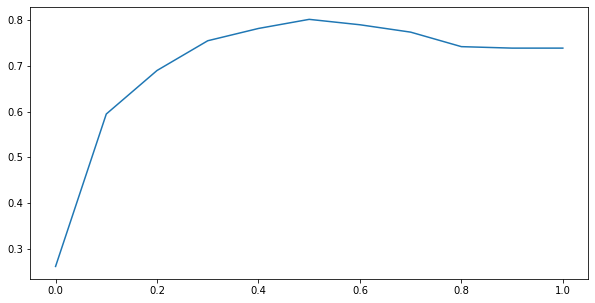

In [44]:
thresholds = np.linspace(0, 1, 11)
accuracies = []

for t in threshold:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    accuracies.append(acc)
    
plt.figure(figsize=(10, 5))    
plt.plot(thresholds, accuracies)

Наилучшая достоверность модели в 80% достигается при срезе прогнозов на пороге 0,5.

### Фиктивная базовая линия

Наша модель дает точность 80%, но хороший ли это показатель? Чтобы это понять, нам нужно связать модель с простой базовой линией. Такой базовой линией может стать фиктивная модель, которая предсказывает одно и то же значение.

У нас несбалансированный датасет, поэтому ушедших клиентов не так много. Поэтому фиктивная модель будет прогнозировать класс большинства как False - нет оттока. 

Создадим этот базовый прогноз:

In [45]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)

Теперь мы можем проверить достоверность этого базового прогноза с помощью accuracy_score

In [46]:
accuracy_score(baseline, y_val)

0.7387096774193549

Достоверность базовой модели составляет 74%. По сравнению с логистической регрессией она хуже всего на 6%. Однако, для того, чтобы сделать полные выводы нам необходимы также другие метрики. Например, матрица ошибок

### Матрица ошибок

В зависимости от прогноза, ответ может быть одним из четырех видов
1. Истинно положительный (TP). Прогноз - отток, в дейсвительности - отток. 
2. Истинно отрицательный (TN). Прогноз - без оттока, в действительности - без оттока.
3. Ложноположительный (FP). Прогноз - отток, в дейсвительности - нет оттока.
4. Ложноотрицательный (FN). Прогноз - без оттока, в дейсвительности - отток

Исходя из ответов для наглядности формируется соответствующая таблица, которая называется матрица ошибок. 

Для этого необходимо рассчитать количество ответов каждого вида

In [47]:
t = 0.5

# Делаем прогнозы при пороговом значении 0,5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)

# Получаем фактические целевые значения
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

# Вычисляем истинно положительные результаты
true_positive = (predict_churn & actual_churn).sum()

# Вычисляем истинно отрицательные результаты
true_negative = (predict_no_churn & actual_no_churn).sum()

# Вычисляем ложноположительные результаты
false_positive = (predict_churn & actual_no_churn).sum()

# Вычисляем ложноотрицательные результаты
false_negative = (predict_no_churn & actual_churn).sum()

# Теперь нам просто требуется объединить все эти значения в массив
confusion_table = np.array(
[[true_negative, false_positive],
[false_negative, true_positive]])

confusion_table

array([[1202,  172],
       [ 197,  289]])

In [48]:
# Преобразуем результат в дроби
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

Модель довольно хорошо прогнозирует отрицательные значения: 65% прогнозов - истинно отрицательные. Однако она допускает довольно много ошибок обоих типов: количество ложноположительных и ложноотрицательных результатов примерно одинаково (9 и 11% соответственно)

### Точность и отклик (Precision & Recall)

Точность и отклик рассчитываются на основе значения матрицы ошибок. Оба показателя помогают оценить качество модели в случае дисбаланса классов

Точность показывает, сколько положительных прогнозов оказались верными. Высчитывается по формуле P = TP / (TP + FP)

In [49]:
precision = true_positive / (true_positive + false_positive)
print('Точность модели:', precision)

Точность модели: 0.6268980477223427


Отклик модели - это доля правильно спрогнозированных клиентов с оттоком (TP) среди всех клиентов, которые ушли  R = TP / (TP + FN)

In [50]:
recall = true_positive / (true_positive + false_negative)
print('Отклик модели:', recall)

Отклик модели: 0.5946502057613169


### Кривая ROC и оценка AUC

Кривая ROC основана на двух величинах: доля ложноположительных результатов (FPR) cреди всех отрицательных и доля истинно положительных (TRP) среди всех положительных примеров

FRT - это доля пользователей, для которых мы спрогнозировали отток, среди всех, кто не подвергся оттоку

TRP - это доля пользователей, для которых мы спрогнозировали отток, среди всех, кто действительно расторг договор

Формулы:

FRT = FP / (FP + TN)

TRP = TP / (TP + FN)

Чем ниже FRT - тем лучше. Чем выше TRP - тем лучше

In [51]:
FRT = false_positive / (false_positive + true_negative)
print('FRT модели:', FRT)

TRP = true_positive / (true_positive + false_negative)
print('TRP модели:', TRP)

FRT модели: 0.12518195050946143
TRP модели: 0.5946502057613169


Нужно проверить метрики при разных пороговых значениях

In [52]:
scores = []

thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    # Вычисляем матрицу ошибок для прогнозов при каждом пороге
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))
    
# Полученные результаты занесем в удобный датафрейм
df_scores = pd.DataFrame(scores)

# Присвоим названия столбцам
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


Теперь можем вычислить показатели TRP и FRP. Мы можем это сделать для всех значений сразу

In [53]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


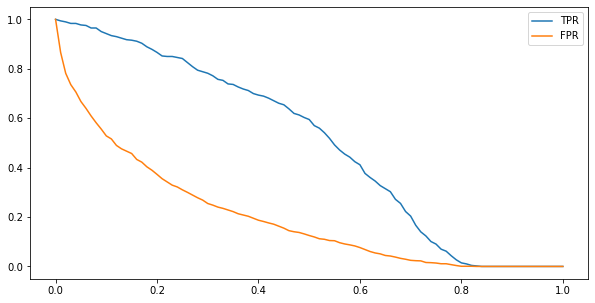

In [54]:
# Построим их график
plt.figure(figsize=(10, 5)) 
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

Чтобы лучше понять показатели TPR и FPR, сравнив их с двумя базовыми моделями: случайной и идеальной. Начнем со случайной.

###  Случайная базовая модель

Случайная модель выдает случайный результат от 0 до 1, независимо от входных данных. Для создания такой модели мы просто сгенерируем массив с однородными случайными числами

In [55]:
# Фиксируем случайное начальное значение для воспроизводимости
np.random.seed(1)

# Генерируем массив со случайными числами между 0 и 1
y_rand = np.random.uniform(0, 1, size=len(y_val))

Расчитаем FPR и TPR для получившейся случайной модели. Чтобы упростить задачу, мы повторно используем код, который написали ранее, и поместим его в функцию

In [56]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)
    
    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))
    
    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

# Теперь используем созданную функцию
df_rand = tpr_fpr_dataframe(y_val, y_rand)

df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


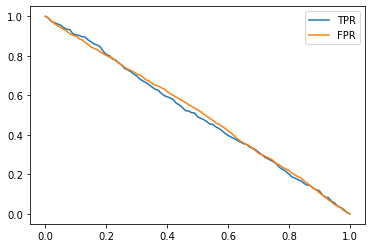

In [57]:
# Теперь построим график
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()

Теперь перейдем к следующей базовой линии и посмотрим как TPR и FPT выглядят для идеальной модели

### Идеальная модель

Идеальная модель всегда принимает правильные решения. Для этого мы ранжируем клиентов. Сначала будут идти клиенты с оттоком, затем без оттока.

In [58]:
# Вычислим количество отрицательных и положительных примеров в наборе данных
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

# Генерируем массив, который сначала вносит num_neg нулей, 
# после чего следуют единицы повторяющихся num_pos количество раз
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

# Вычисляем кривые TPR и FPR для классификатора
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)

df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


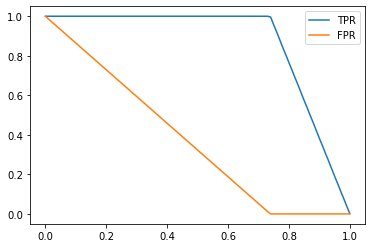

In [59]:
# Теперь построим график
plt.plot(df_rand.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_rand.threshold, df_ideal.fpr, label='FPR')
plt.legend()

### Кривая ROC. Метрика AUC

Для лучшего понимания эффектиности модели существует специальный график, который назыается кривой ROC. Его суть заключается в отображении соотношения между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак, и  долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признаки.

Построим указанный график для нашей, случайной и идеальной моделей

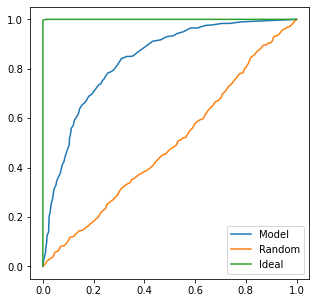

In [60]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')
plt.legend()

Оценивая наши модели с помощью кривой ROC, мы хотим, чтобы они оказывались как можно ближе к идеальной точке, и как можно дальше от случайной базовой линии. Для этого можно измерить площадь под кривой ROC. Такая метрика имеет специальное название AUC (area under [ROC] curve)

In [61]:
auc(df_scores.fpr, df_scores.tpr)

0.8359150837721111

AUC составляет 0,83, что соответствует характеристикам нормальной модели, близкой к хорошей.

## Настройка парметров

### К-кратная перекрестная проверка

Мы можем использовать все данные для оценки качества. Для этого мы можем просто выполнить проверку несколько раз. Сначала разделим набор данных на определенное количество частей (допустим, на три). Затем обучаем модель на двух частях и проверяем на оставшейся. Повторяем трижды, получаем три разные оценки. Именно это называется К-кратной перекрестной проверкой.

Но перед этим упростим процесс обучения. Для этого поместим весь код для обучения в функцию train

In [62]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    
    X = dv.transform(cat)
    
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)
    
    return dv, model

Аналогичным образом мы помещаем логику прогнозирвоания в функцию predict

In [63]:
def predict(df, dv, model):
    cat =  df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

Теперь можем реализовать перекрестную проверку

In [64]:
# Создадим класс kfold и разделим данные на 10 частей
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

aucs = []

# Проходим по десяти различным разбиением данных
for train_idx, val_idx in kfold.split(df_train_full):
    # разбиваем данные на обучающий и проверочный набор
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    #Обучаем модель и делаем прогнозы
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    # Оцениваем качество модели на проверочных данных
    auc = roc_auc_score(y_val, y_pred)
    
    #сохраняем AUC в списке с результатами
    aucs.append(auc)
    
aucs

[0.8493392490816277,
 0.8413366336633662,
 0.8590269587894291,
 0.8330260883877869,
 0.8242555831265509,
 0.840959040959041,
 0.8437154021491371,
 0.8223355471220746,
 0.8450718838002075,
 0.8611811367685119]

Мы получили распределения балов для нашей модели. Посмотрим на среднее значение и стандартное отклонение

In [65]:
print('auc = %0.3f +/- %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.842 +/- 0.012


Мы видим что стандартное отклонение довольно маленькое. Это говорит о том, что наша модель стабильна. Теперь мы можем использовать К-кратную перекрестную проверку для настройки параметров (выбора наилучших параметров)

### Поиск наилучших параметров

Модель, которую мы обучали ранее, использовала значение по умолчанию для параметра С, который управляет степенью регуляризации. Выберем процедуру перекрестной проверки для выбора наилучшего параметра С. Для этого  мы немного настроим функцию train, чтобы она принимала один дополнительный парметр

In [66]:
def train(df, y, C):
    cat = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False) 
    dv.fit(cat)
    X = dv.transform(cat)
    model = LogisticRegression(solver='liblinear', C=C) 
    model.fit(X, y)
    return dv, model

Теперь найдем лучший парамтр С. Сначала сделаем цикл с различными значениями С. Для каждого С выполним перекрестную проверку. Записываем среднее значение AUC, а также стандартное отклонение

In [67]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)
for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.839 ± 0.009
C=0.1, auc = 0.841 ± 0.007
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


После С=0.1 средняя AUC остается прежней,однако стандартное отклонение меньше для С=0.5, поэтому выбираем С=0.5

Теперь нужно сделать последний шаг: обучить модель на всех обучающих и проверочных наборах данных, после чего применить ее к тестовому набору, чтобы убедиться, что она действительно хорошо работает

In [68]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, 0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858


Нам удалось обучить модель с метрикой ROC AUC равной 0.858, что соответствует характеристикам хорошей модели.

## ЗАКЛЮЧЕНИЕ

Перед нами была задача бинарной классификации, поскольку мы прогнозировали только два класса: отток (положительный класс), либо его отсутствие (отрицательный класс).

В ходе предварительного исследования данных, мы выяснили:
- Пожилые клиенты, клиенты имеющие помесячный способ оплаты и клиенты без технической поддержки - более всех склонны попадать в отток.
- Такие характиеристики как пол, наличие телефонной службы и нескольких телефонных линий - менее всего влияют на отток.
- Клиенты, пользующиеся услугами более двух лет - очень редко расторгают договоры.

Для решения задачи классификации нами была обучена модель логистической регрессии. 

При оптимизации модели (настойки параметров) был подбран парметр регуляризации "С", которому мы установили значение 0,5.

Тестирование модели показало, что метрика AUC составляет 0.858, что соответствует характеристикам хорошей модели.

Таким образом, все цели исследования были достигнуты